# Projeto: PIT19457-2022
# Etapa 2

# <span style="color: #4C72B0">Matheus Gomes Diniz Andrade</span>

---

# 1.0 Introdução

O presente _notebook_ tem como objetivo desenvolver a <ins>**Tarefa**</ins> proposta na Etapa 2 do edital PIT19457-2022. A tarefa consiste em:
1. Ralizar uma análise exploratória dos atributos contínuos, discretos e textuais do dataset;
2. Aplicar alguma técnica de processamento de linguagem natural de sua livre escolha, utilizando as colunas textuais. Como sugestões (mas não limitado): modelagem de tópicos, reconhecimento de entidades nomeadas, classificação, sumarização etc.
3. Opcionalmente, expor o modelo para realização de inferência por meio de uma API REST.

## 1.1 Informações Gerais

O **dataset** contém informações gerais de **5.000 processos** julgados nos Juizados Especiais Federais dentro das Seções Judiciárias do Tibunal Regiaonal da 5a Região.

- **Sentença**: decisão final de primeira instância
- **Recurso**: Ocorre quando a parte que perdeu o processo pede que um colegiado de juízes modifique a sentença

O mesmo **dataset** possui **46 colunas** das quais **2** possuem texto livre:
- `conteudo_sentenca` - é classificada por meio dos rótulos presentes na coluna `resultado_1_grau`.
- `conteudo_acordao` - é classificada por meio dos rótulos presentes na coluna `resultado_2_grau`.

Todo processo terá uma sentença, mas não um acórdão, visto que este depende da vontade da parte de recorrer do julgamento obtido na sentença.

# 2.0 Importando bibliotecas

In [1]:
import nltk
import unidecode
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import seaborn           as sns

from scipy.stats import normaltest
from wordcloud   import WordCloud
from nltk        import tokenize
from string      import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection         import train_test_split
from sklearn.svm                     import LinearSVC

# 3.0 Definição de funções e padrões de plotagem

In [2]:
def generate_wordcloud(resultado_1_grau, conteudo):
    all_words = ' '.join([text for text in dataset.query("resultado_1_grau == @resultado_1_grau")[conteudo]])
    word_cloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(all_words)
    
    return word_cloud

In [3]:
def generate_top10_words(resultado_1_grau, conteudo):
    todas_palavras = ' '.join([text for text in dataset.query("resultado_1_grau == @resultado_1_grau")[conteudo]])
    token_espaco = tokenize.WhitespaceTokenizer()
    token_palavras = token_espaco.tokenize(todas_palavras)
    
    frequencias = nltk.FreqDist(token_palavras)
    frequencias = pd.DataFrame({"Palavra": list(frequencias.keys()), "Frequência": list(frequencias.values())})
    frequencias = frequencias.nlargest(columns="Frequência", n=10)

    palavras = frequencias['Palavra']
    contagem = frequencias['Frequência']
    
    return palavras, contagem

In [4]:
sns.set_theme()

args = {
    'title_size': 26,
    'xlabel_size': 16,
    'ylabel_size': 16,
}

# 4.0 Aquisição dos dados

In [5]:
path = './data/sample.parquet'

In [6]:
dataset = pd.read_parquet(path)

dataset.head()

,num_processo,data_ajuizamento,data_primeira_movimentacao_processual,data_ultima_movimentacao,autor,reu,tutela_antecipada,vara,titular_substituto,classe_atual,...,resultado_1_grau,conteudo_sentenca,n_dias_ate_sentenca,n_tokens_sentenca,relator_acordao,data_sessao_tr,data_acordao,conteudo_acordao,resultado_2_grau,n_tokens_acordao
0,0500454-62.2017.4.05.8402,2017-03-06,2017-03-06 11:01:00,2017-10-30 10:07:00,Lourival Francisco da Silva (027.173.384-54)\n...,Fazenda Nacional (00.394.460/0239-40)\nMunicíp...,N,9-RN,Titular,Execução de Título Judicial,...,PROCEDENTE,SENTENÇA 1. Relatório Cuida-se de ação propost...,76.307593,1309,Almiro José da Rocha Lemos,2017-08-09 09:00:00,2017-08-14 10:46:34,PROCESSO 0500454-62.2017.4.05.8402 EMENTA:DIR...,NÃO PROVIMENTO,381.0
1,0517700-16.2013.4.05.8013,2013-10-09,2013-10-09 20:54:00,NaT,MARIA LUCIA CARDOSO (382.242.084-00)\nEmanuel ...,Caixa Econômica Federal (00.360.305/0001-04),N,9-AL,Titular,Procedimento do Juizado Especial Cível,...,EXTINTO SEM MÉRITO,"SENTENÇA Trata-se de ação especial cível, em c...",20.844491,263,NaN,NaT,NaT,None,NaN,0.1
2,0502388-07.2007.4.05.8305,2007-07-13,2007-07-13 13:51:00,NaT,QUITÉRIA BARBOSA DA SILVA NASCIMENTO (062.819....,Instituto Nacional do Seguro Social - INSS (29...,N,23-PE,Titular,Procedimento do Juizado Especial Cível,...,EXTINTO SEM MÉRITO,SENTENÇA Vistos etc. Trata-se de ação especial...,143.822245,956,NaN,NaT,NaT,None,NaN,0.1
3,0503551-02.2014.4.05.8103,2014-04-02,2014-04-02 11:02:00,NaT,Emanuela Carneiro Tabosa (777.839.723-49)\nBru...,UNIÃO (FAZENDA NACIONAL) - Procuradoria da Faz...,N,19-CE,Titular,Procedimento do Juizado Especial Cível,...,PROCEDENTE,SENTENÇA I - RELATÓRIO Cuida-se de ação em que...,21.360567,3037,CÍNTIA MENEZES BRUNETTA,2014-06-25 13:30:00,2014-06-27 16:14:43,"VOTO Relatório dispensado, nos termos do art. ...",NÃO PROVIMENTO,1214.0
4,0503488-94.2016.4.05.8300,2016-03-21,2016-03-21 11:04:00,2019-02-19 13:16:00,Lúcio Flavio de Lima Albuquerque (095.403.004-...,ANGELA MARIA DO NASCIMENTO SILVA (157.771.544-...,N,19-PE,Substituto,Procedimento do Juizado Especial Cível,...,IMPROCEDENTE,SENTENÇA Tipo A I – RELATÓRIO Dispensado o rel...,784.066493,2099,Joaquim Lustosa Filho,2018-06-19 10:00:00,2018-06-19 15:01:56,EMENTA PREVIDENCIÁRIO. PENSÃO POR MORTE. PROVA...,NÃO PROVIMENTO,1962.0


# 5.0 Análise Exploratória

## 5.1 Informações iniciais do dataset

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 46 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   num_processo                           5000 non-null   object        
 1   data_ajuizamento                       5000 non-null   datetime64[ns]
 2   data_primeira_movimentacao_processual  5000 non-null   datetime64[ns]
 3   data_ultima_movimentacao               3362 non-null   datetime64[ns]
 4   autor                                  5000 non-null   object        
 5   reu                                    5000 non-null   object        
 6   tutela_antecipada                      5000 non-null   category      
 7   vara                                   5000 non-null   category      
 8   titular_substituto                     5000 non-null   category      
 9   classe_atual                           5000 non-null   category

É possível observar que, pelas informações obtidas inicialmente, se simplesmente retirasse dados **nulos**, só pela coluna `data_liminar` o dataset pederia <span style="color: #4C72B0">**4722**</span> linhas de informação.

Como visto anteriormente:
>"Todo processo terá uma sentença, mas não um acórdão"
<br>
<br>
Trecho retirado do arrquivo fornecido na Etapa 2 do processo seletivo.

Sendo assim, retirar os **nulos** das colunas que dizem respeito ao **acórdão** iria remover muitas informações importantes.

## 5.2 Veriáveis categóricas

Abaixo estarão análises de algumas variáveis categóricas do dataset

### 5.2.1 `tutela_antecipada`

>"Significa que um juiz ou uma juíza permitiu que o autor obtenha antecipadamente algo que foi pedido no processo. De todo modo, a ação continuará tramitando até o seu julgamento final".
<br>
<br>
[Fonte](https://www.tjdft.jus.br/informacoes/significado-dos-andamentos/andamentos/332)

In [8]:
dataset['tutela_antecipada'].value_counts()

N    4007
S     993
Name: tutela_antecipada, dtype: int64

O valor **S** provavelmente representa um "Sim" e o **N** um "Não".

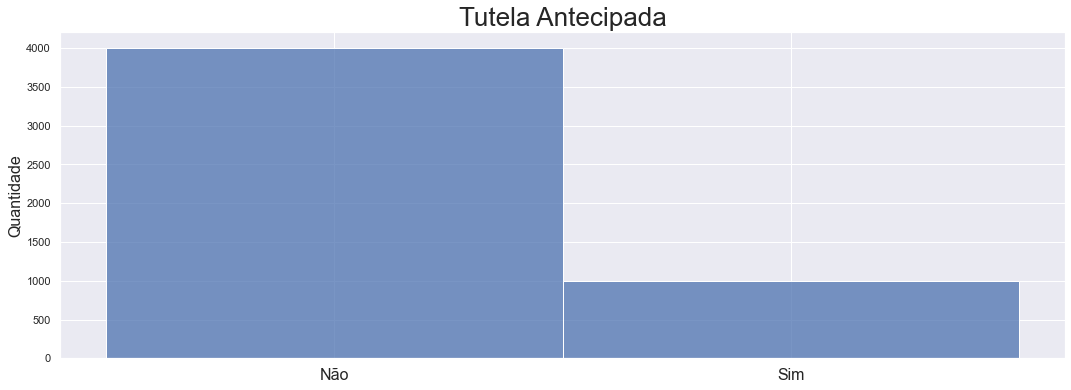

In [9]:
plt.figure(figsize=(18, 6))

sns.histplot(dataset, x='tutela_antecipada')

plt.title("Tutela Antecipada", fontsize=args['title_size'])
plt.ylabel("Quantidade", fontsize=args['ylabel_size'])
plt.xticks(ticks=['N', 'S'], labels=['Não', 'Sim'], fontsize=args['xlabel_size'])
plt.xlabel("")

plt.show()

In [10]:
dataset['tutela_antecipada'].value_counts(normalize=True) * 100

N    80.14
S    19.86
Name: tutela_antecipada, dtype: float64

<span style="color: #4C72B0">**80,14%**</span> dos dados do dataset <span style="color: #4C72B0">**Não**</span> coseguiram tutela antecipada.

### 5.2.2 `vara`

>"A vara judiciária é o local ou repartição que corresponde a lotação de um juiz, onde o magistrado efetua suas atividades."
<br>
<br>
[Fonte](https://www.tjap.jus.br/portal/publicacoes/noticias/5206-os-conceitos-e-diferen%C3%A7as-entre-comarca,-vara,-entr%C3%A2ncia-e-inst%C3%A2ncia.html)

In [11]:
dataset['vara'].value_counts()

6-AL     226
7-PB     200
9-AL     174
3-RN     160
7-RN     159
        ... 
33-PE      0
22-PE      0
11-PE      0
33-CE      0
9-CE       0
Name: vara, Length: 75, dtype: int64

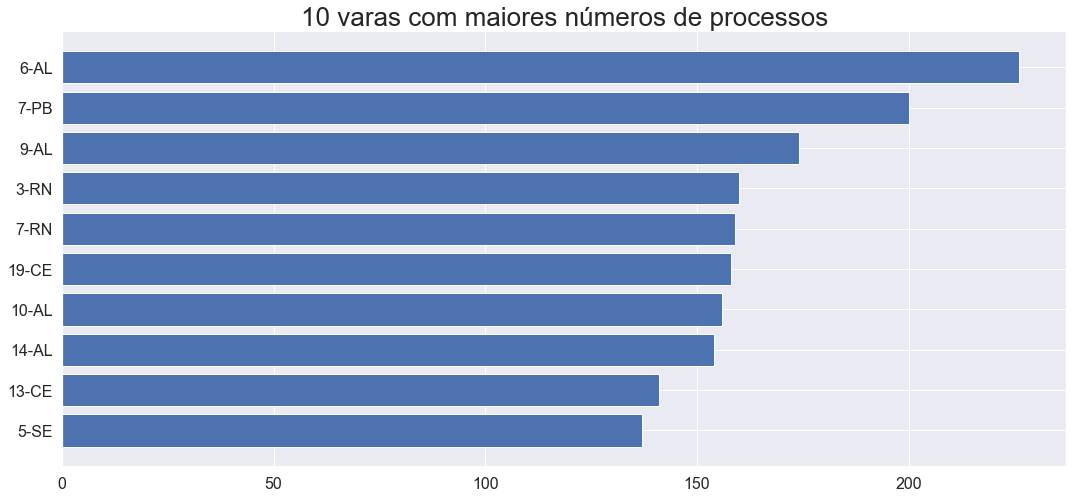

In [12]:
plt.figure(figsize=(18, 8))

plt.barh(
    dataset['vara'].value_counts(ascending=True).index[-10:], 
    width=dataset['vara'].value_counts(ascending=True).values[-10:]
)

plt.title("10 varas com maiores números de processos", fontsize=args['title_size'])
plt.yticks(fontsize=args['ylabel_size'])
plt.xticks(fontsize=args['xlabel_size'])

plt.show()

In [13]:
(dataset['vara'].value_counts(normalize=True)[:10] * 100).sum()

33.3

Essas mesmas 10 varas recebream <span style="color: #4C72B0">**33,3%**</span> dos processos presentes no dataset.

### 5.2.3 `titular_substituto`

A coluda diz respeito ao cargo de **Titular** ou **Substituto** do juiz.

In [14]:
dataset['titular_substituto'].value_counts()

Titular                                2422
Substituto                             2392
Ce - Juizado Especial Federal Cível     141
SJCE (Subseção Judiciária de Tauá)       45
Name: titular_substituto, dtype: int64

In [15]:
dataset['titular_substituto'].value_counts(normalize=True) * 100

Titular                                48.44
Substituto                             47.84
Ce - Juizado Especial Federal Cível     2.82
SJCE (Subseção Judiciária de Tauá)      0.90
Name: titular_substituto, dtype: float64

- Titular : <span style="color: #4C72B0">**48,44%**</span>
- Substituto : <span style="color: #4C72B0">**47,84%**</span>
- Ce - Juizado Especial Federal Cível : <span style="color: #4C72B0">**2,82%**</span>
- SJCE (Subseção Judiciária de Tauá) : <span style="color: #4C72B0">**0,90%**</span>

Como é possível perceber, alguns dados possivelmente foram cadastrados de maneira indevida com **Ce - Juizado Especial Federal Cível** e **SJCE (Subseção Judiciária de Tauá)**. Esses representam <span style="color: #4C72B0">**3,72%**</span> dos dados presentes no dataset.

### 5.2.4 `assunto_cnj`

In [16]:
dataset['assunto_cnj'].value_counts()

Direito Previdenciário                                                                                4059
Direito Administrativo e outras matérias do Direito Público                                            471
Direito do Consumidor                                                                                  171
Direito Civil                                                                                          146
Direito Tributário                                                                                     129
Direito Processual Civil e do Trabalho                                                                  12
Direito do Trabalho                                                                                     11
Direito Penal                                                                                            1
Direito Previdenciário - Benefícios em Espécie                                                           0
Pagamento de cota residual decorrente

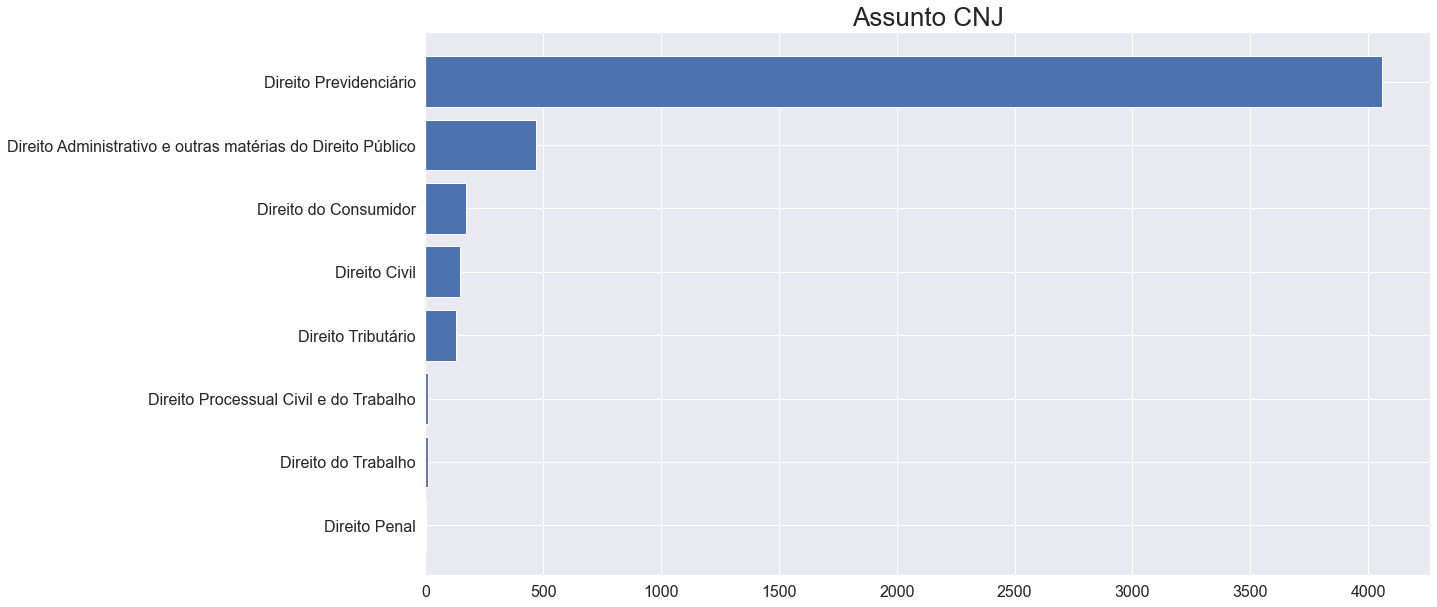

In [17]:
assunto_cnj_dif_0 = dataset['assunto_cnj'].value_counts(ascending=True)[-8:]


plt.figure(figsize=(18, 10))

plt.barh(
    assunto_cnj_dif_0.index, 
    width=assunto_cnj_dif_0.values
)

plt.title("Assunto CNJ", fontsize=args['title_size'])
plt.yticks(fontsize=args['ylabel_size'])
plt.xticks(fontsize=args['xlabel_size'])

plt.show()

In [18]:
(dataset['assunto_cnj'].value_counts(normalize=True) * 100)[0]

81.17999999999999

Se tratando do assunto CNJ (Conselho Nacional da Justiça), somente o **Direito Previdenciário** representa <span style="color: #4C72B0">**81,18%**</span> dos processos contidos no dataset.

>"O Direito Previdenciário tem como objetivo garantir os direitos dos cidadãos brasileiros quanto à assistência e Previdência Social, relacionadas a morte, idade e doenças. Ou seja, quanto à Previdência Social".
<br>
<br>
[Fonte](https://cmpprev.com.br/blog/o-que-e-direito-previdenciario/)

### 5.2.5 `complemento_assunto_cnj`

In [19]:
dataset['complemento_assunto_cnj'].value_counts()

Benefícios em Espécie                                           3617
Servidor Público Civil                                           275
RMI - Renda Mensal Inicial, Reajustes e Revisões Específicas     214
Pedidos Genéricos Relativos aos Benefícios em Espécie            199
Organização Político-administrativa / Administração Pública      132
                                                                ... 
Objetos de cartas precatórias/de ordem                             0
Processo Administrativo Fiscal                                     0
Ministério Público                                                 0
Formação, Suspensão e Extinção do Processo                         0
Comissão Parlamentar de Inquérito - CPI                            0
Name: complemento_assunto_cnj, Length: 98, dtype: int64

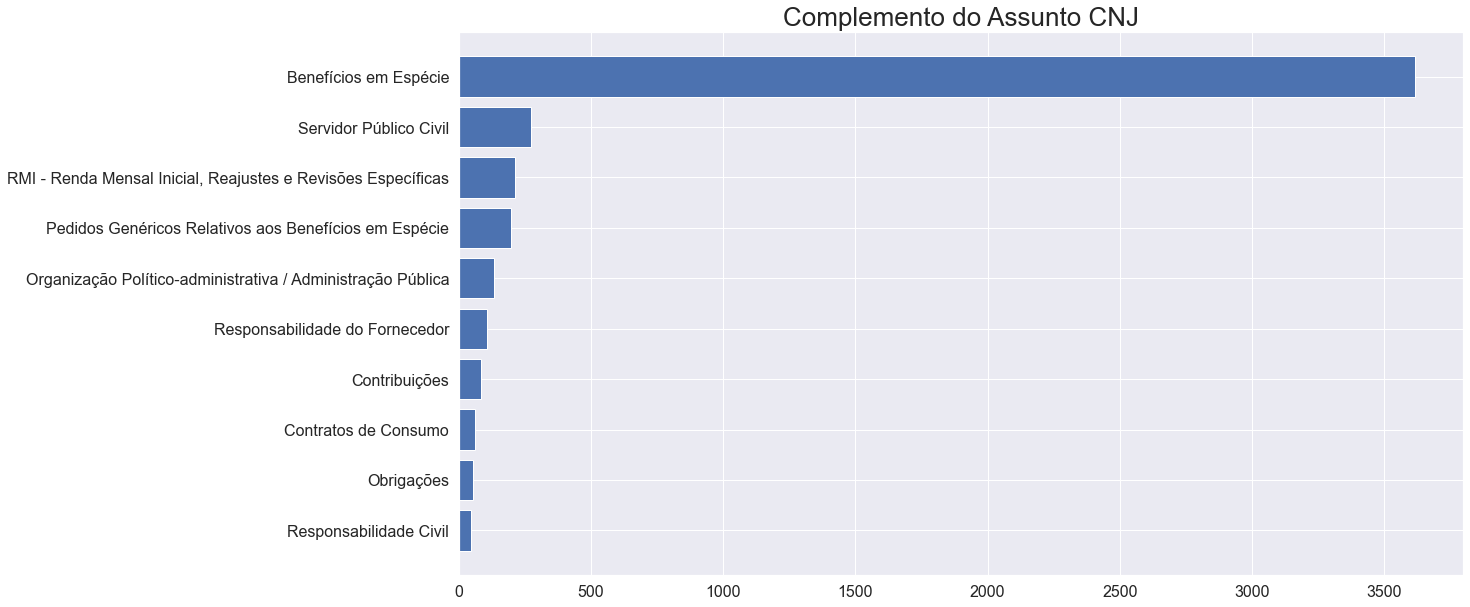

In [20]:
complemento_assunto_cnj_10_maiores = dataset['complemento_assunto_cnj'].value_counts(ascending=True)[-10:]


plt.figure(figsize=(18, 10))

plt.barh(
    complemento_assunto_cnj_10_maiores.index, 
    width=complemento_assunto_cnj_10_maiores.values
)

plt.title("Complemento do Assunto CNJ", fontsize=args['title_size'])
plt.yticks(fontsize=args['ylabel_size'])
plt.xticks(fontsize=args['xlabel_size'])

plt.show()

In [21]:
(dataset['complemento_assunto_cnj'].value_counts(normalize=True) * 100)[0]

72.99697275479315

Dentro do assunto, o complemento do assunto **Benefícios em Espécie** corresponde a <span style="color: #4C72B0">**73%**</span> dos dados contidos no dataset.

### 5.2.6 `detalhe_assunto_cnj`

In [22]:
dataset['detalhe_assunto_cnj'].value_counts()

Auxílio-Doença Previdenciário                                  1330
Benefício Assistencial (Art. 203,V CF/88)                       821
Aposentadoria por Idade (Art. 48/51)                            464
Aposentadoria por Invalidez                                     324
Salário-Maternidade (Art. 71/73)                                247
                                                               ... 
Professores                                                       0
Licenças e Folgas - Conversão em Pecúnia                          0
IPVA - Imposto Sobre Propriedade de Veículos Automotores          0
Habilitação / Registro Cadastral / Julgamento / Homologação       0
Quebra de Sigilo Bancário / Fiscal / Telefônico                   0
Name: detalhe_assunto_cnj, Length: 399, dtype: int64

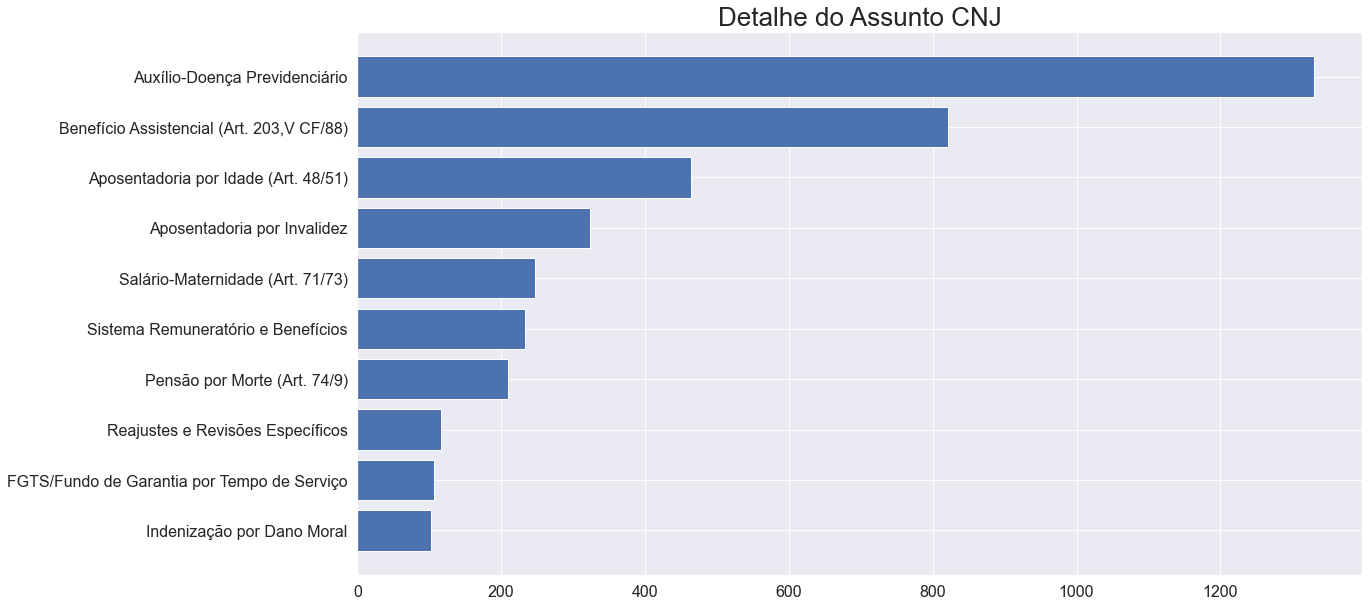

In [23]:
detalhe_assunto_cnj_10_maiores = dataset['detalhe_assunto_cnj'].value_counts(ascending=True)[-10:]


plt.figure(figsize=(18, 10))

plt.barh(
    detalhe_assunto_cnj_10_maiores.index, 
    width=detalhe_assunto_cnj_10_maiores.values
)

plt.title("Detalhe do Assunto CNJ", fontsize=args['title_size'])
plt.yticks(fontsize=args['ylabel_size'])
plt.xticks(fontsize=args['xlabel_size'])

plt.show()

In [24]:
(dataset['detalhe_assunto_cnj'].value_counts(normalize=True) * 100)[0]

26.966747769667478

**Auxílio-Doença Previdenciário** representa <span style="color: #4C72B0">**26,97%**</span> dos processos presentes no dataset.

>"O auxílio-doença previdenciário é um benefício pago pelo INSS ao segurado que se encontra temporariamente incapacitado para o seu trabalho habitual por mais de 15 dias consecutivos, em decorrência de uma doença comum ou uma doença grave."
<br>
<br>
[Fonte](https://arraesecenteno.com.br/guia-completo-do-auxilio-doenca-previdenciario/#:~:text=O%20aux%C3%ADlio%2Ddoen%C3%A7a%20previdenci%C3%A1rio%20%C3%A9,comum%20ou%20uma%20doen%C3%A7a%20grave.)

In [25]:
(dataset['detalhe_assunto_cnj'].value_counts(normalize=True) * 100)[1]

16.64639091646391

Já **Benefício Assistencial (Art. 203,V CF/88)** representa <span style="color: #4C72B0">**16,65%**</span> dos processos presentes no dataset.

>"Casos onde se pretende o pagamento de um salário mínimo, garantido às pessoas portadoras de deficiência e aos idosos com 67 anos ou mais que não tenham meios de prover a própria subsistência nem de tê-la provida por sua família. Complementar a classificação com um dos assuntos de Pedidos genéricos relativos aos benefícios em espécie"
<br>
<br>
[Fonte](https://www.cnj.jus.br/sgt/consulta_publica_assuntos.php)

Juntos representam <span style="color: #4C72B0">**43,62%**</span> dos processos no dataset.

### 5.2.7 `juizado_itinerante`

>"O itinerante existe desde agosto de 1998 e tem a mesma competência dos juizados especiais cíveis, ou seja, atende causas de até 40 salários mínimos, não havendo, para causas de até 20 salários, necessidade de se constituir advogado."
<br>
<br>
[Fonte](https://www.tjsp.jus.br/Especialidade/Itinerante)

In [26]:
dataset['juizado_itinerante'].value_counts()

N    4969
S      31
Name: juizado_itinerante, dtype: int64

Sendo assim, apenas <span style="color: #4C72B0">**31**</span> dos processos presentes no dataset são causas inferiores à 40 salários mínimos.

### 5.2.8 `prioridade_processual`

>Conforme garantido em lei, tem prioridade de tramitação as seguintes pessoas, como parte ou interessado:
> - Com idade igual ou superior a 60 anos de idade;
> - Que tenha doença grave;
> - Criança ou adolescente;
> - Vítima de violência doméstica e familiar;
> - Pessoa com deficiência.<br><br>
[Fonte](https://previdenciarista.com/blog/prioridade-de-tramitacao-quem-tem-direito-e-como-requerer/)

In [27]:
dataset['prioridade_processual'].value_counts()

N    4372
S     628
Name: prioridade_processual, dtype: int64

Sendo assim, <span style="color: #4C72B0">**628**</span> dos processos se enquadram em pelo menos uma das classes citadas acima.

### 5.2.9 `liminar`

>"A decisão liminar é aquela proferida em caráter de urgência, para garantir ou antecipar um direito que tem perigo de ser perdido."
<br>
<br>
[Fonte](https://www.tjdft.jus.br/institucional/imprensa/campanhas-e-produtos/direito-facil/edicao-semanal/decisao-liminar-x-sentenca-de-merito)

In [28]:
dataset['liminar'].value_counts()

SEM PEDIDO LIMINAR       4722
INDEFERIDA                243
DEFERIDA                   34
PARCIALMENTE DEFERIDA       1
Name: liminar, dtype: int64

<span style="color: #4C72B0">**4722**</span> dos processos ocorreram sem pedido de **liminar**.

## 5.3 Dados Numéricos

Irei explorar agora dados numéricos que acredito que podem adicionar informações estatísticas (juntamente com as já vistas anteriormente), como duração do processo, por exemplo.

### 5.3.1 `processo_arquivado`

In [29]:
processo_arquivado = dataset.query("processo_arquivado == 1").copy()
data_arquivamento = processo_arquivado['data_arquivamento']
data_primeira_movimentacao_processual = processo_arquivado['data_primeira_movimentacao_processual']

processo_arquivado['n_dias_arquivamento'] = (data_arquivamento - data_primeira_movimentacao_processual).dt.days

processo_arquivado['n_dias_arquivamento']

0        233
4       1065
5        365
6        141
7         82
        ... 
4990     132
4994      14
4995      25
4997     403
4998     101
Name: n_dias_arquivamento, Length: 3096, dtype: int64

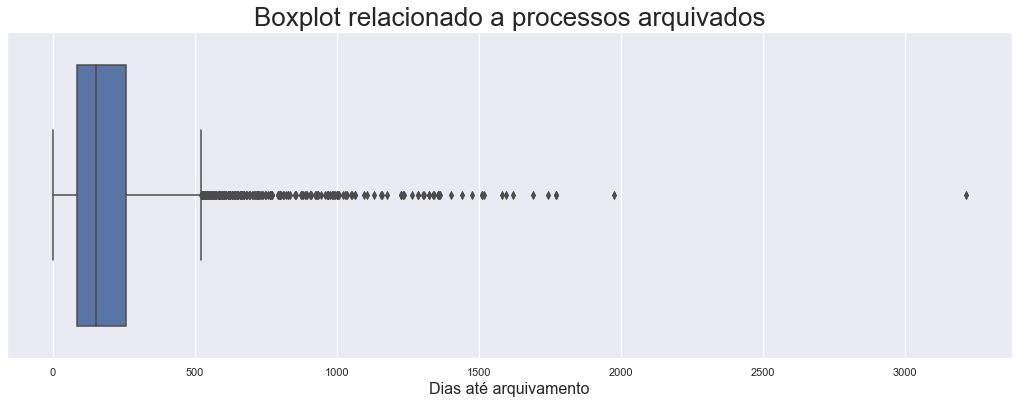

In [30]:
plt.figure(figsize=(18, 6))

sns.boxplot(x=processo_arquivado['n_dias_arquivamento'])

plt.title("Boxplot relacionado a processos arquivados", fontsize=args['title_size'])
plt.xlabel("Dias até arquivamento", fontsize=args['xlabel_size'])

plt.show()

In [31]:
sem_outliers = [value for value in processo_arquivado['n_dias_arquivamento'] if value <= processo_arquivado['n_dias_arquivamento'].quantile(0.75)]

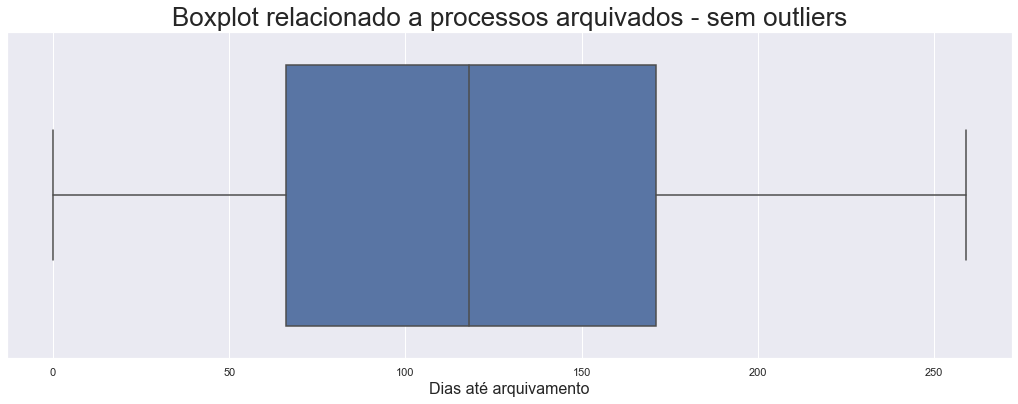

In [32]:
plt.figure(figsize=(18, 6))

sns.boxplot(x=sem_outliers)

plt.title("Boxplot relacionado a processos arquivados - sem outliers", fontsize=args['title_size'])
plt.xlabel("Dias até arquivamento", fontsize=args['xlabel_size'])

plt.show()

In [33]:
np.mean(sem_outliers)

119.6236559139785

In [34]:
np.median(sem_outliers)

118.0

In [35]:
stat_test, p_valor = normaltest(sem_outliers)

p_valor <= 0.05

True

Removendo os outliers é possivel ver que, para um níve de confiança de <span style="color: #4C72B0">**95%**</span> o período de um processo até seu arquivamento segue uma distribuição normal.

Podemos concluir que processos que são arquivados levam em média <span style="color: #4C72B0">**119**</span> dias até serem arquivados.

Como comentário extra: Esses processos exigem uma determinada logística e empenho que, se identificado um padrão entre os processos que são arquivados, poderia se pensar na criação de um modelo preditivo que classificasse inicialmente se um processo teria chance de ser arquivado para que esse fosse análisado com antecedência com intuito de otimizar o tempo gasto com o mesmo.

### 5.3.2 `data_acordao`

>"Quando o processo vai para o Tribunal, ele é analisado não apenas por um, mas por três juízes, chamados de desembargadores. Ao final dessa análise, os desembargadores chegam à sua conclusão sobre o processo, entrando em uma espécie de acordo sobre ela. Essa decisão coletiva é chamada de ACÓRDÃO. Quando o acórdão é publicado, significa que o conteúdo da decisão do Tribunal está disponível para consulta. Mas atenção! O acórdão é uma decisão dos juízes e não tem nada a ver com possíveis acordos feitos entre as partes."
<br>
<br>
[Fonte](https://www.trt4.jus.br/portais/trt4/glossario)

In [36]:
mask = dataset['data_acordao'].notna()
acordao = dataset[mask].copy()

data_acordao = acordao['data_acordao']
data_primeira_movimentacao_processual = acordao['data_primeira_movimentacao_processual']

acordao['n_dias_acordao'] = (data_acordao - data_primeira_movimentacao_processual).dt.days

acordao['n_dias_acordao']

0       160
3        86
4       820
5       323
8       162
       ... 
4987    112
4989    479
4993    505
4996    452
4997    305
Name: n_dias_acordao, Length: 1363, dtype: int64

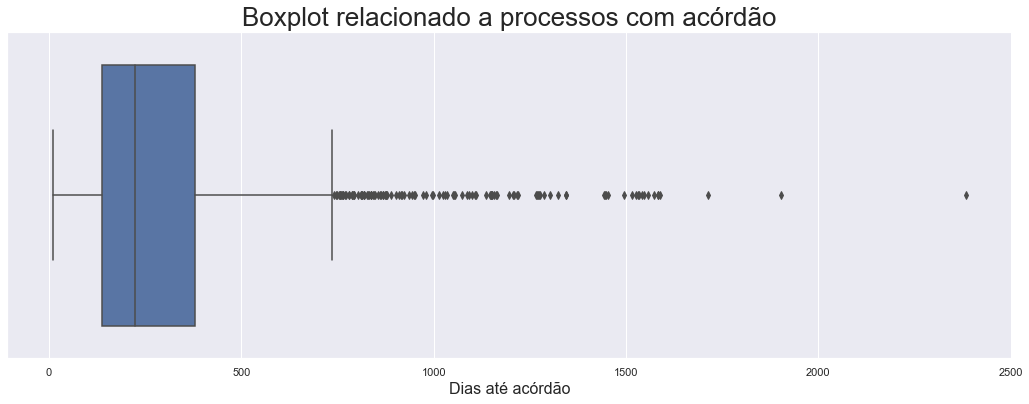

In [37]:
plt.figure(figsize=(18, 6))

sns.boxplot(x=acordao['n_dias_acordao'])

plt.title("Boxplot relacionado a processos com acórdão", fontsize=args['title_size'])
plt.xlabel("Dias até acórdão", fontsize=args['xlabel_size'])

plt.show()

In [38]:
sem_outliers = [value for value in acordao['n_dias_acordao'] if value <= acordao['n_dias_acordao'].quantile(0.75)]

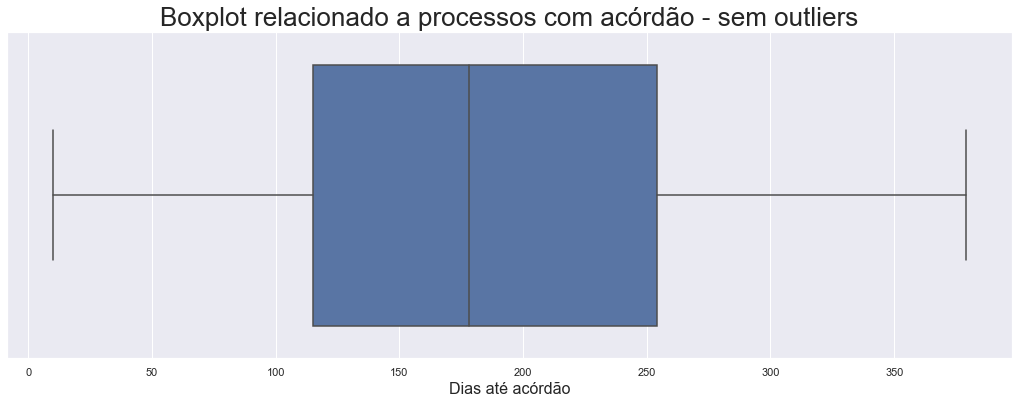

In [39]:
plt.figure(figsize=(18, 6))

sns.boxplot(x=sem_outliers)

plt.title("Boxplot relacionado a processos com acórdão - sem outliers", fontsize=args['title_size'])
plt.xlabel("Dias até acórdão", fontsize=args['xlabel_size'])

plt.show()

In [40]:
np.mean(sem_outliers)

188.50243902439024

In [41]:
np.median(sem_outliers)

178.0

In [42]:
stat_test, p_valor = normaltest(sem_outliers)

p_valor <= 0.05

True

Removendo os outliers é possivel ver que, para um níve de confiança de <span style="color: #4C72B0">**95%**</span>, o período de um processo até a data de acórdão segue uma distribuição normal.

Podemos concluir que processos com acórdão levam em média <span style="color: #4C72B0">**188**</span> dias.

## 5.4 Dados Textuais

Os dados textuais que serão analisados em questão estão presentes nas colunas `conteudo_sentenca` e `conteudo_acordao`.

### 5.4.1 `conteudo_sentenca`

In [43]:
dataset['conteudo_sentenca']

0       SENTENÇA 1. Relatório Cuida-se de ação propost...
1       SENTENÇA Trata-se de ação especial cível, em c...
2       SENTENÇA Vistos etc. Trata-se de ação especial...
3       SENTENÇA I - RELATÓRIO Cuida-se de ação em que...
4       SENTENÇA Tipo A I – RELATÓRIO Dispensado o rel...
                              ...                        
4995    SENTENÇA Vistos etc. Trata-se de ação especial...
4996    PODER JUDICIÁRIO JUSTIÇA FEDERAL NO CEARÁ 21a ...
4997    JUSTIÇA FEDERAL SEÇÃO JUDICIÁRIA DO ESTADO DO ...
4998     SENTENÇA 1.Relatório Trata-se de ação especia...
4999     SENTENÇA Trata-se de ação proposta contra a C...
Name: conteudo_sentenca, Length: 5000, dtype: object

Cada linha representa o **conteúdo da sentença** que, por sua vez, é relacionado com a coluna `resultado_1_grau`. Observando como está estruturada essa linha:

In [44]:
print(f"{dataset['resultado_1_grau'][0]}: ")
dataset['conteudo_sentenca'][0]

PROCEDENTE: 


'SENTENÇA 1. Relatório Cuida-se de ação proposta em face da FAZENDA NACIONAL e MUNICÍPIO DE LAGOA NOVA, na qual a parte autora objetiva a devolução de valores retidos na fonte a título de PSS incidente sobre parcelas de terço constitucional de férias. É o sucinto relatório, que seria até dispensado, nos termos do parágrafo único do art. 38 da Lei no 9.099/1995, aplicável subsidiariamente aos Juizados Especiais Federais, em consonância com o art. 1o da Lei no 10.259/2001. 2. Fundamentação Do benefício da gratuidade judiciária Tendo em vista que a autora possui rendimento inferior ao teto do RGPS, conforme fichas financeiras acostadas aos autos, critério este que se reputo razoável para fins de concessão da benesse legal, defiro o pleito de justiça gratuita. Da ausência de documentos indispensáveis à propositura da ação Quanto à alegação de ausência de documentos indispensáveis à propositura da ação, consistente na necessidade de comprovação dos valores de tributos retidos, igualmente nã

Pode-se utilizar um tipo de visualização bastante utilizada quando se trata de textos, as **WordClouds**. Irei gerar uma WordCloud para cada resultado de primeiro grau possível, para facilitar a visualização das palavras que compõem o conteudo da sentença dado o seu resultado.

In [45]:
dataset['resultado_1_grau'].cat.categories

Index(['EXTINTO SEM MÉRITO', 'HOMOLOGADA TRANSAÇÃO', 'IMPROCEDENTE',
       'PARCIALMENTE PROCEDENTE', 'PROCEDENTE'],
      dtype='object')

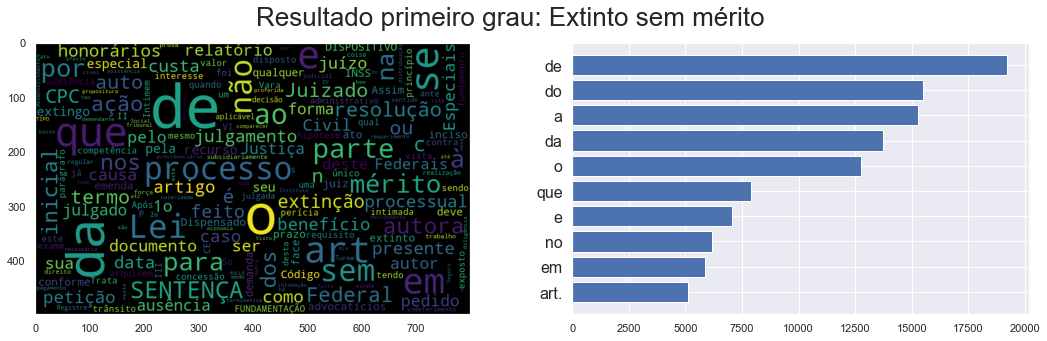

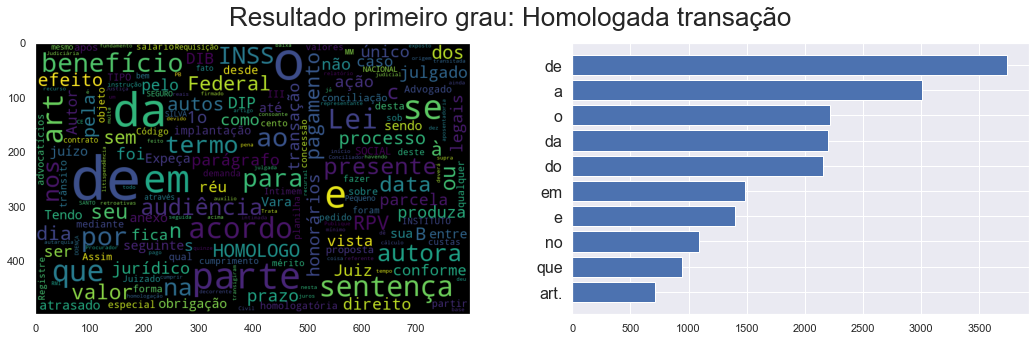

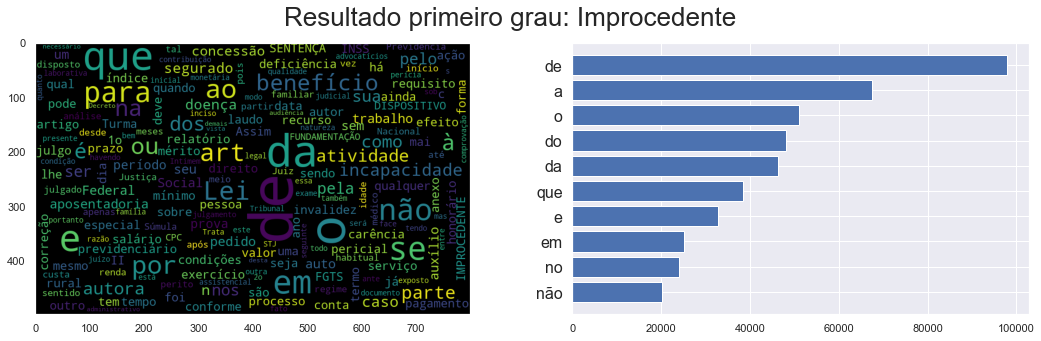

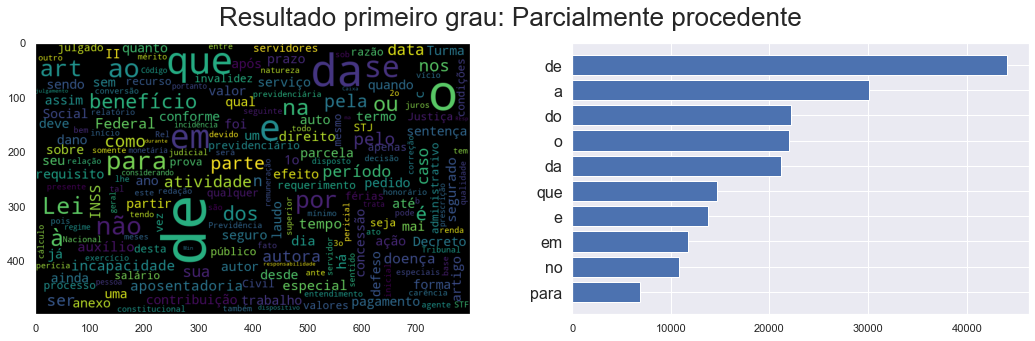

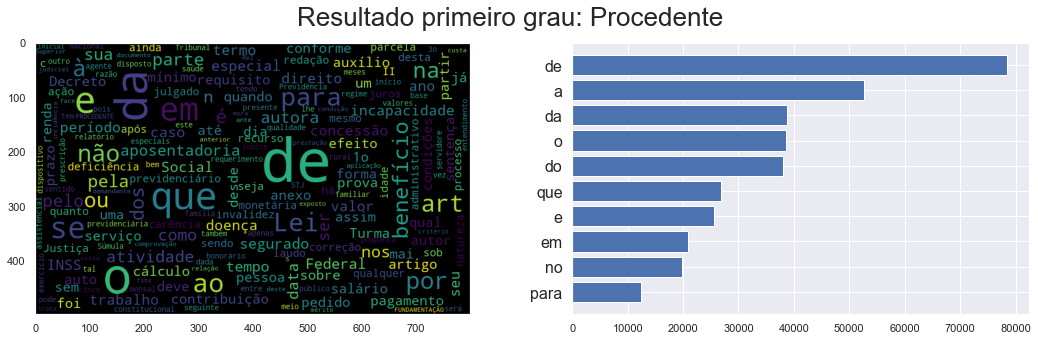

In [46]:
for resultado in dataset['resultado_1_grau'].cat.categories:
    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    
    ax[0].imshow(generate_wordcloud(resultado, 'conteudo_sentenca'))
    ax[0].grid(False)
    
    feature_names, feature_names_count = generate_top10_words(resultado, 'conteudo_sentenca')
    ax[1].barh(feature_names, width=feature_names_count)
    ax[1].tick_params(axis='y', labelsize=args['ylabel_size'])
    ax[1].invert_yaxis()
    
    plt.suptitle(f"Resultado primeiro grau: {resultado.capitalize()}", fontsize=args['title_size'])
    plt.show()

Com avisualização fica bem mais evidente um fator possívelmente problemático em análises:

- Parte dos elementos em maior destaque são conhecidos na grámatica como **Artigos**, **Preposições** e **Conjunções**.

São palavras extremamente usuáis no Português e por isso apareceram frequentemente em todos os texto. Mas esses tipos de palavras, por aparecerem com grande frequência em todos os textos, provavelmente não nos permitiria classificar um texto com uma boa precisão.

Em <span style="color: #4C72B0">**Processamento de Linguagem Natural**</span> essas palavras são conhecidas como <span style="color: #4C72B0">**Stop Words**</span>.

In [47]:
stop_words = nltk.corpus.stopwords.words("portuguese")
pontuacao  = list(punctuation)

palavras_irrelevantes = stop_words + pontuacao

In [48]:
stemmer = nltk.RSLPStemmer()
texto_processado = []

for conteudo_sentenca in dataset['conteudo_sentenca']:
    conteudo_sentenca = unidecode.unidecode(conteudo_sentenca)
    novo_conteudo_sentenca = []
    
    token_pontuacao = tokenize.WordPunctTokenizer()
    token_palavras  = token_pontuacao.tokenize(conteudo_sentenca)
    
    for palavra in token_palavras:
        if palavra.lower() not in palavras_irrelevantes:
            novo_conteudo_sentenca.append(stemmer.stem(palavra))
            
    texto_processado.append(' '.join(novo_conteudo_sentenca))

dataset['conteudo_sentenca_tratado'] = texto_processado    

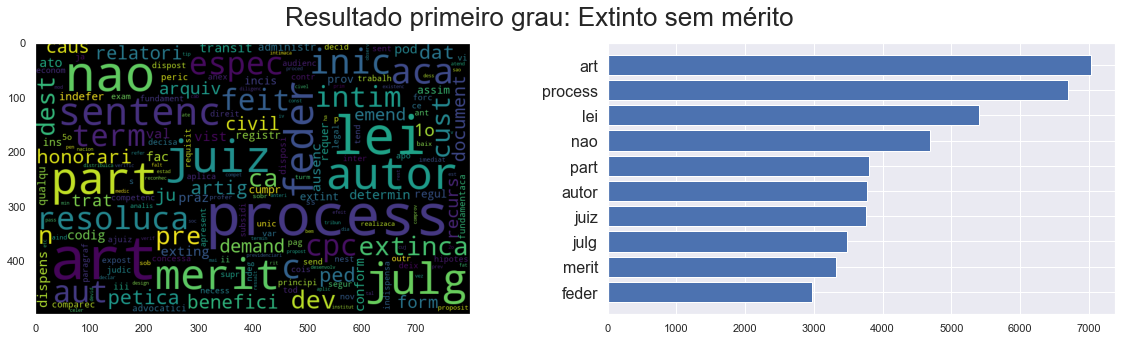

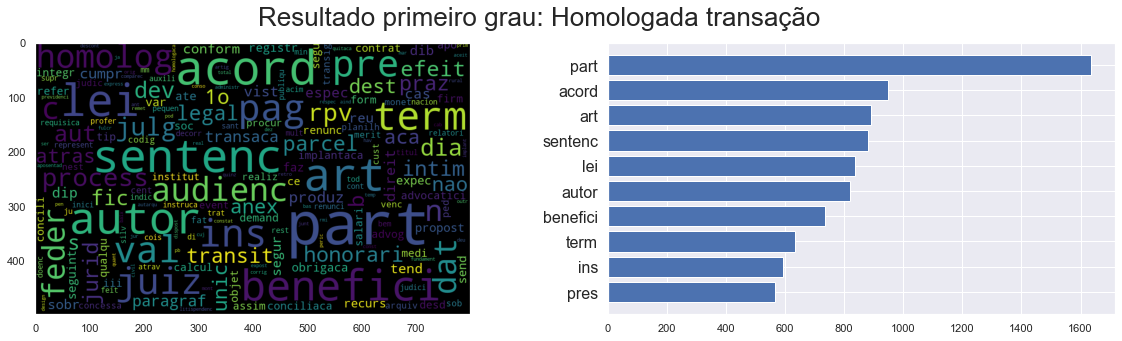

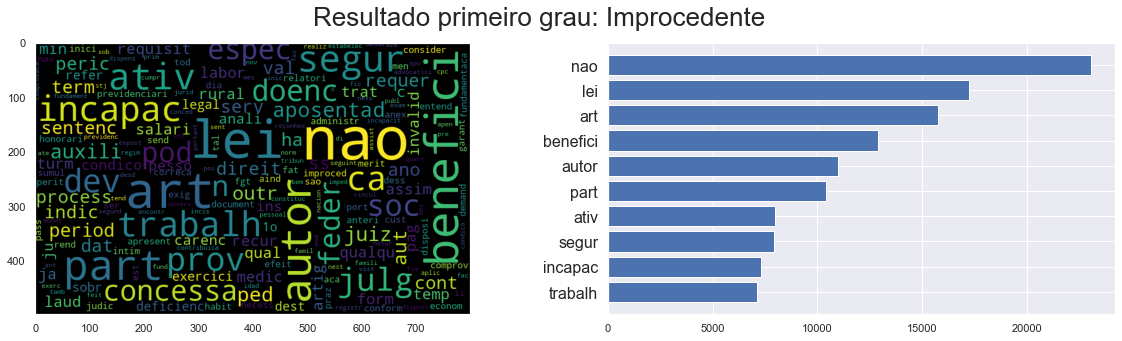

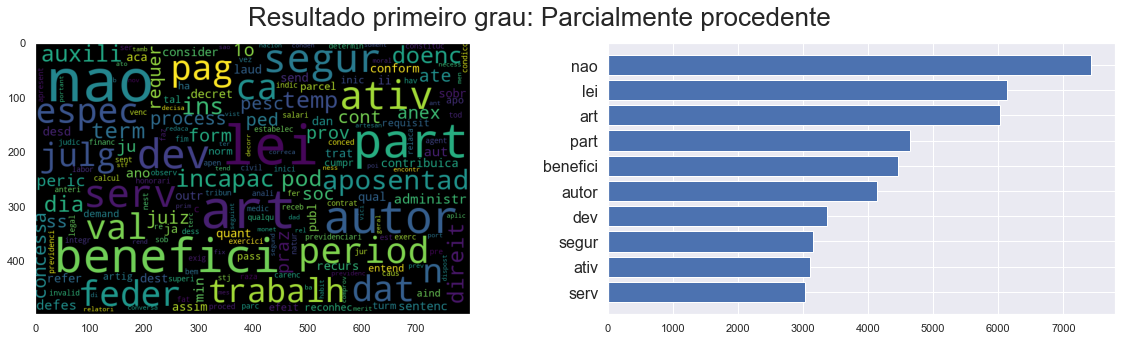

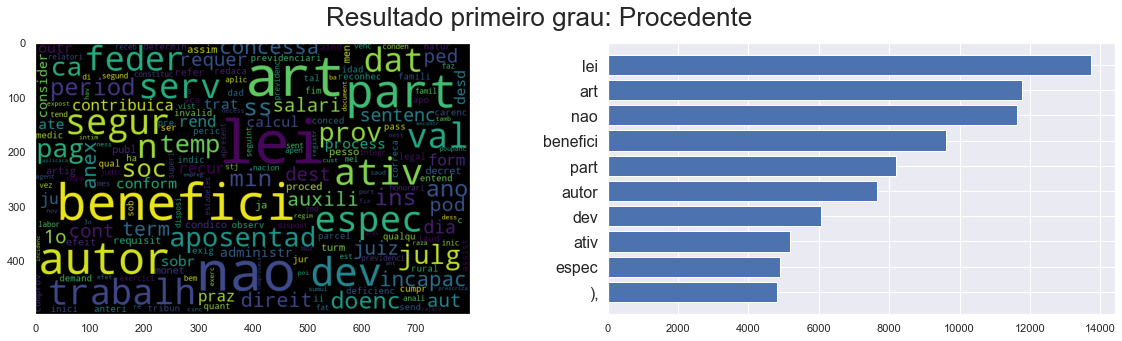

In [49]:
for resultado in dataset['resultado_1_grau'].cat.categories:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    ax[0].imshow(generate_wordcloud(resultado, 'conteudo_sentenca_tratado'))
    ax[0].grid(False)
    
    feature_names, feature_names_count = generate_top10_words(resultado, 'conteudo_sentenca_tratado')
    ax[1].barh(feature_names, width=feature_names_count)
    ax[1].tick_params(axis='y', labelsize=args['ylabel_size'])
    ax[1].invert_yaxis()
    
    plt.suptitle(f"Resultado primeiro grau: {resultado.capitalize()}", fontsize=args['title_size'])
    plt.show()

Só nesse tratamento inicial, retirei **pontuações** e **Stop Words**. Além disso, passei a considerar agora a **raiz** da palavra para impedir certas repetições que ocorreriam como "federal", "federais" e "federação", por exemplo.

In [50]:
dataset['resultado_1_grau'].cat.categories

Index(['EXTINTO SEM MÉRITO', 'HOMOLOGADA TRANSAÇÃO', 'IMPROCEDENTE',
       'PARCIALMENTE PROCEDENTE', 'PROCEDENTE'],
      dtype='object')

In [51]:
dataset['classificacao_1'] = dataset['resultado_1_grau'].replace(
    ['EXTINTO SEM MÉRITO', 'HOMOLOGADA TRANSAÇÃO', 'IMPROCEDENTE','PARCIALMENTE PROCEDENTE', 'PROCEDENTE'],
    [0                   , 1                     , 2             , 3                       , 4           ]
)

In [52]:
tfidf   = TfidfVectorizer(lowercase=False, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(dataset['conteudo_sentenca_tratado'])

Considerando a técnica <span style="color: #4C72B0">**TF-IDF**</span> é possivel dar menos peso as palavras presentes em todos os textos e mais pesos aquelas que são quase que exclusiva de um grupo específico de textos.

Além disso, foi considerado a existência de <span style="color: #4C72B0">**bigrams**</span>. O que gera um peso para sequenências de duas palavras.

## 6.0 Criação do Modelo

A função do modelo abaixo é inferir o **resultado de primeiro grau** a partir da entrada de um texto já tratado.

In [53]:
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X_tfidf,
    dataset['classificacao_1'],
    random_state=42
)

In [54]:
linear_svc = LinearSVC()

linear_svc.fit(X_treino, y_treino)

LinearSVC()

In [55]:
linear_svc.score(X_teste, y_teste)

0.932